<img width="350" style="float:right" 
     src="https://cdn.i.haymarketmedia.asia/?n=campaign-asia%2Fcontent%2FcroppedF1logo.png&h=570&w=855&q=100&v=20170226&c=1" />

# Formula 1 Analysis Group F

Enrique Recke\
Pieter Van Poecke\
Nitya Biyani\
María Aguilera García\
Cinthia Panayotti\
Juan Francisco Espinosa\
Felipe Restrepo

<a id='0'></a>
## Description
<p>
<div>The goal for this lab is to find relevant answers for these business questions:</div>
<ul>    
    <li>Which are the places with most user's interactions in order to propose a new race location?</li>
    <li>Which are the most common drivers and teams in certain locations to be able to plan more accurate marketing campaigns.

<a id='1'></a>
## 1. PySpark environment setup

To setup our PySpark environment we:
1. Search for Spark Installation
2. Create SparkSession

<a id='1.1'></a>
### 1.1 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()

We change pandas max column width property in order to improve data displaying.

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.2'></a>
### 1.2 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster

In [3]:
# To access catalogue in Hive
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

The first thing always is to create the SparkSession

In [4]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Twitter Analytics - DataFrames")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .config("spark.sql.legacy.timeParserPolicy","LEGACY")
    .enableHiveSupport()
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<a id='2'></a>
## 2. Data source and Spark data abstraction (DataFrame) setup


- In order to get an overview of the industry, we imported 5 csv files from Kaggle with historical F1 records from 1950 to July 2021.
- Specifically, we download the following files:
    1. Teams (constructors)
    2. Races
    3. Results
    4. Drivers
    5. Circuits

*Link*: https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020?select=races.csv

We choose to infer the schema of the datasets as there is too many columns and datasets.

In [5]:
circuitsDF = spark.read.option("inferSchema", "true")\
                    .option("header", "true")\
                    .csv("1.FormulaOne_Lab/F1_HistoricalData/circuits.csv")\
                    .cache() #optimization to make processing faster

teamsDF = spark.read.option("inferSchema", "true")\
                    .option("header", "true")\
                    .csv("1.FormulaOne_Lab/F1_HistoricalData/constructors.csv")\
                    .cache()\

racesDF = spark.read.option("inferSchema", "true")\
                    .option("header", "true")\
                    .csv("1.FormulaOne_Lab/F1_HistoricalData/races.csv")\
                    .cache()

resultsDF = spark.read.option("inferSchema", "true")\
                    .option("header", "true")\
                    .csv("1.FormulaOne_Lab/F1_HistoricalData/results.csv")\
                    .cache()

driversDF = spark.read.option("inferSchema", "true")\
                .option("header", "true")\
                .csv("1.FormulaOne_Lab/F1_HistoricalData/drivers.csv")\
                .cache()

<a id='3'></a>
## 3. Data sets Meta Analysis

<a id='3.1'></a>
## 3.1 Circuits Data Set

Circuits where F1 races are held.

In [6]:
from IPython.display import display, Markdown
circuitsDF.printSchema()
display(Markdown("This Circuits DataFrame has **%d rows**." % circuitsDF.count()))

root
 |-- circuitId: integer (nullable = true)
 |-- circuitRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- alt: integer (nullable = true)
 |-- url: string (nullable = true)



This Circuits DataFrame has **77 rows**.

<a id='3.2'></a>
## 3.2  Teams (constructors)  Data Set

Constructors in F1

In [7]:
teamsDF.printSchema()
display(Markdown("This Teams Results DataFrame has **%d rows**." % teamsDF.count()))

root
 |-- constructorId: integer (nullable = true)
 |-- constructorRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)



This Teams Results DataFrame has **211 rows**.

<a id='3.3'></a>
## 3.3  Drivers Data Set

Drivers in F1.

In [8]:
driversDF.printSchema()
display(Markdown("This Teams Results DataFrame has **%d rows**." % driversDF.count()))

root
 |-- driverId: integer (nullable = true)
 |-- driverRef: string (nullable = true)
 |-- number: string (nullable = true)
 |-- code: string (nullable = true)
 |-- forename: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)



This Teams Results DataFrame has **853 rows**.

<a id='3.4'></a>
## 3.4 Races Data Set

Races in F1.

In [9]:
racesDF.printSchema()
display(Markdown("This Teams Results DataFrame has **%d rows**." % racesDF.count()))

root
 |-- raceId: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- round: integer (nullable = true)
 |-- circuitId: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- url: string (nullable = true)



This Teams Results DataFrame has **1058 rows**.

<a id='3.5'></a>
## 3.5  Results Data Set

Results of F1 Races.

In [10]:
resultsDF.printSchema()
display(Markdown("This Teams Results DataFrame has **%d rows**." % resultsDF.count()))

root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- number: string (nullable = true)
 |-- grid: integer (nullable = true)
 |-- position: string (nullable = true)
 |-- positionText: string (nullable = true)
 |-- positionOrder: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- laps: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: string (nullable = true)
 |-- fastestLap: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- fastestLapTime: string (nullable = true)
 |-- fastestLapSpeed: string (nullable = true)
 |-- statusId: integer (nullable = true)



This Teams Results DataFrame has **25140 rows**.

Here we are importing all the libraries for the further analysis.

In [11]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

<a id='4'></a>
# 4. Kaggle Dataset Analysis 

(From 1950 to July 2021)


## 4.1  How has the number of races changed over the years?

In [12]:
racesDF.toPandas().head(5)

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix


In [13]:
numberRaces = racesDF[['raceId','year']]\
            .groupby('year')\
            .agg(F.count("*")\
            .alias("races"))\
            .sort(F.col('year').asc()).toPandas()
numberRaces

,year,races
0,1950,7
1,1951,8
2,1952,8
3,1953,9
4,1954,9
...,...,...
67,2017,20
68,2018,21
69,2019,21
70,2020,17


Text(0, 0.5, '# of Races')

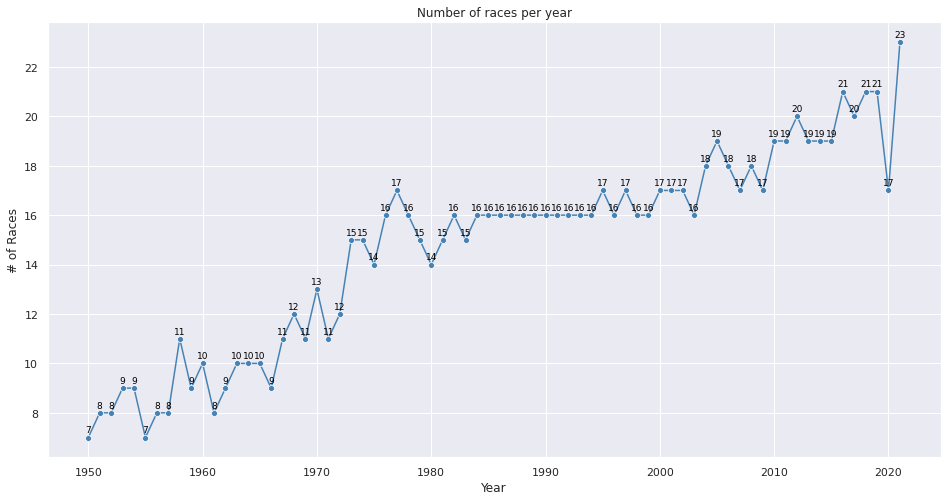

In [14]:
plt.figure(figsize=(16, 8))
sns.set(style="darkgrid")
sns.lineplot(x="year", y="races", data=numberRaces, color="steelblue", marker="o")
# adding chart title
plt.title('Number of races per year')

# adding labels on bar chart
for index, row in numberRaces.iterrows():
    plt.text(row.year, row.races + 0.2, row.races, color='black', ha="center", size=9)
    
# adding custom labels for axes
plt.xlabel("Year")
plt.ylabel("# of Races")

<a id='4.2'></a>
## 4.2 Top 5 Winning Teams

Here we are joining the teams data set and teams results data sets to get the teams with more points (1950 -July 2021).

In [15]:
team_resultsDF = resultsDF.join(teamsDF,teamsDF.constructorId==resultsDF.constructorId)\
                         .cache()

most_winning_teamsDF = team_resultsDF\
                    .groupBy("name")\
                    .agg(F.sum("points").alias("totalPoints"))\
                    .sort(F.col("totalPoints").desc())\
                    .toPandas().head(5)
most_winning_teamsDF

,name,totalPoints
0,Ferrari,9414.77
1,Mercedes,6066.14
2,McLaren,5864.50
3,Red Bull,5329.50
4,Williams,3567.00


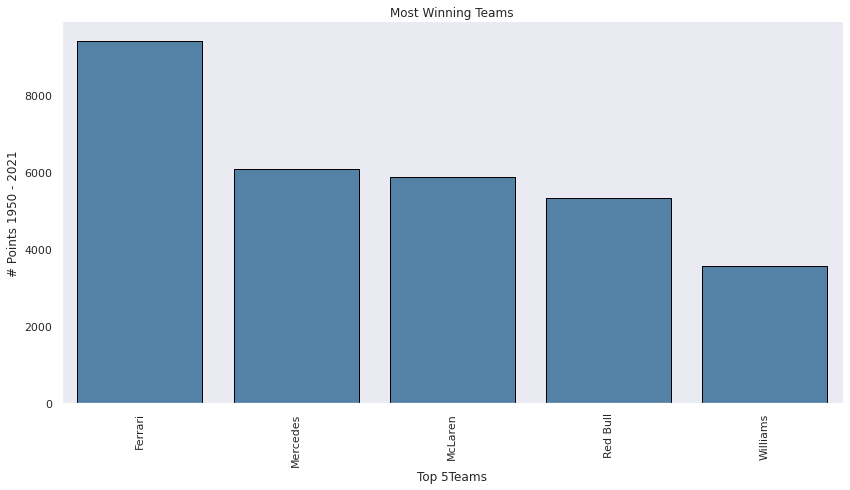

In [16]:
top_n = 5

plt.figure(figsize=(14, 7))
sns.set(style="dark")
sns.barplot(x="name", y="totalPoints", data=most_winning_teamsDF[:top_n], color="steelblue", edgecolor="black")

# adding chart title
plt.title('Most Winning Teams')


# adding custom labels for axes
plt.xlabel("Top " + str(top_n) + "Teams")
plt.ylabel("# Points 1950 - 2021")


# rotating axis labels
plt.xticks(rotation=90)

sns.despine()

<a id='4.3'></a>
## 4.3 Top 20 Winning Drivers

- We are adding the age column to the drivers table and then joining with the results table to get the drivers with more races won.

In [17]:
driversDF = driversDF.withColumn(("age"), F.round(F.datediff(F.col("current_date"),F.col("dob"))/365,0))
driversDF.show(5)

+--------+----------+------+----+--------+----------+----------+-----------+--------------------+----+
|driverId| driverRef|number|code|forename|   surname|       dob|nationality|                 url| age|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+----+
|       1|  hamilton|    44| HAM|   Lewis|  Hamilton|1985-01-07|    British|http://en.wikiped...|37.0|
|       2|  heidfeld|    \N| HEI|    Nick|  Heidfeld|1977-05-10|     German|http://en.wikiped...|45.0|
|       3|   rosberg|     6| ROS|    Nico|   Rosberg|1985-06-27|     German|http://en.wikiped...|36.0|
|       4|    alonso|    14| ALO|Fernando|    Alonso|1981-07-29|    Spanish|http://en.wikiped...|40.0|
|       5|kovalainen|    \N| KOV|  Heikki|Kovalainen|1981-10-19|    Finnish|http://en.wikiped...|40.0|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+----+
only showing top 5 rows



In [18]:
drivers_results = resultsDF.join(driversDF,resultsDF.driverId == driversDF.driverId)\
                        .where(resultsDF["position"] == 1)\
                        .groupBy("forename","surname","age")\
                        .agg(F.count("*").alias("racesWon"))\
                        .sort(F.col("racesWon").desc())\
                        .toPandas()
drivers_results.head(20)

,forename,surname,age,racesWon
0,Lewis,Hamilton,37.0,98
1,Michael,Schumacher,53.0,91
2,Sebastian,Vettel,34.0,53
3,Alain,Prost,67.0,51
4,Ayrton,Senna,62.0,41
5,Fernando,Alonso,40.0,32
6,Nigel,Mansell,68.0,31
7,Jackie,Stewart,83.0,27
8,Niki,Lauda,73.0,25
9,Jim,Clark,86.0,25


<a id='4.4'></a>
## 4.4 Number of Races per Country

- Here we are joining races and circuits tables to find the Top 10 countries that have hosted the most races.

In [19]:
number_of_races_per_countriesDF = racesDF.join(circuitsDF, racesDF.circuitId == circuitsDF.circuitId)\
                                .groupBy("country")\
                                .agg(F.count("*").alias("numRacesPerCountry"))\
                                .sort(F.col("numRacesPerCountry").desc())\
                                .limit(15)\
                                .toPandas()
number_of_races_per_countriesDF

,country,numRacesPerCountry
0,Italy,102
1,Germany,79
2,UK,76
3,USA,71
4,Monaco,67
5,Belgium,66
6,France,62
7,Spain,58
8,Canada,50
9,Brazil,48


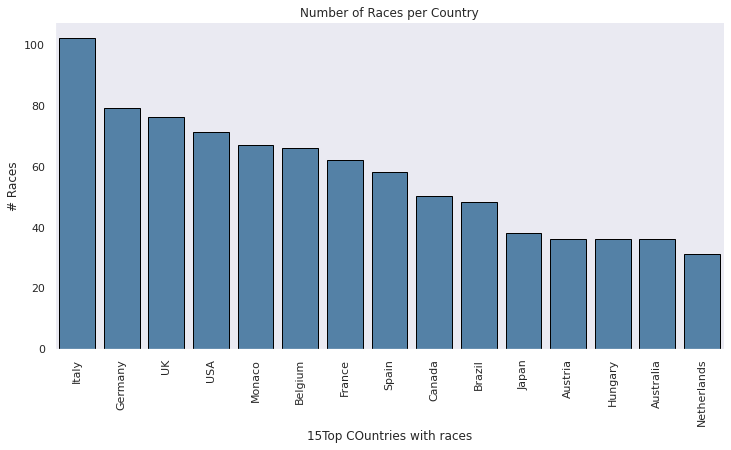

In [20]:
top_n = 15

plt.figure(figsize=(12, 6))
sns.set(style="dark")
sns.barplot(x="country", y="numRacesPerCountry", data=number_of_races_per_countriesDF[:top_n], color="steelblue", edgecolor="black")

# adding chart title
plt.title('Number of Races per Country')

# adding custom labels for axes
plt.xlabel(str(top_n) + "Top COuntries with races")
plt.ylabel("# Races")

# rotating axis labels
plt.xticks(rotation=90)

sns.despine()

<a id='4.5'></a>
## 4.5 Number of Races per City
- Here we are joining races and circuits tables to find the Top 10 cities that have hosted the most races.

In [21]:
number_of_races_per_citiesDF = racesDF.join(circuitsDF, racesDF.circuitId == circuitsDF.circuitId)\
                            .groupBy("location")\
                            .agg(F.count("*").alias("numRacesPerCity"))\
                            .sort(F.col("numRacesPerCity").desc())\
                            .limit(15)\
                            .toPandas()

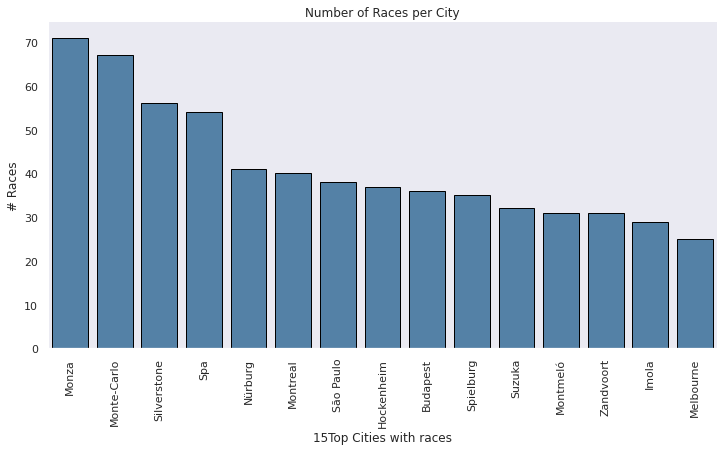

In [22]:
top_n = 15

plt.figure(figsize=(12, 6))
sns.set(style="dark")
sns.barplot(x="location", y="numRacesPerCity", data=number_of_races_per_citiesDF[:top_n], color="steelblue", edgecolor="black")

# adding chart title
plt.title('Number of Races per City')

# adding custom labels for axes
plt.xlabel(str(top_n) + "Top Cities with races")
plt.ylabel("# Races")

# rotating axis labels
plt.xticks(rotation=90)

sns.despine()

# 5. Tweets Analysis

<a id='5.1'></a>
## 5.1 Check Twitter Files

We checked if our ingested data was saved properly in the following HDFS directory: 

`hdfs://localhost:9000//datalake/raw/f1/tweets/*/*/*/*`

Notice that we use `*` since we have stored the data using a date structure of `year/month/day/files`.

Tweet Object Model: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

<a id='5.2'></a>
## 5.2 Create the DataFrame

Here we are creating the DataFrames with the stored tweets in order to do some metadata and data inspection to answer the business questions.

In [23]:
tweets = (spark.read
               .json("hdfs://localhost:9000//datalake/raw/f1/tweets/*/*/*/*"))
tweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

In [24]:
# tweets.first()

<a id='5.3'></a>
## 5.3 Getting an Overview of the Tweets

**Total number of tweets**<br/>


In [25]:
tweets.count()

413042

**Total number of distinct users**<br/>

In [26]:
tweets.select("user.id").distinct().count()

205045

**Total number of users with geolocation enabled**<br/>

In [27]:
tweets.where("user.geo_enabled=true").select("user.id").distinct().count()

92358

**Total number of tweets per language**<br/>

- Here we found that almost all of the tweets were written in english.

In [28]:
tweets.select("lang").distinct().count()

51

<AxesSubplot:ylabel='lang'>

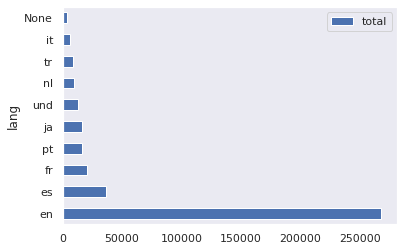

In [29]:
df_lang = (tweets
      .groupBy("lang")
      .agg(F.count("*").alias("total"))
      .orderBy(F.desc("total")))
      
df_lang.toPandas().head(10).plot.barh(x = 'lang', y = 'total')

- Here we were just verifying that the text language matches with the labeled language.

In [30]:
tweets_lang = tweets.select('lang','text')
tweets_lang.toPandas().head(10)

,lang,text
0,es,RT @marca: 👏👏👏 ¡¡Un adelantamiento para la historia de la #F1!! Así pasó Verstappen a Hamilton en la última vuelta del #AbuDhabiGP https:/…
1,en,"RT @F1: RED BULL: ""MAX VERSTAPPEN - YOU ARE WORLD CHAMPION!"" 🎧🏆\n\n#AbuDhabiGP 🇦🇪 #F1 https://t.co/4oAei8sPR8"
2,en,RT @SunRisers: #OrangeArmy = best fans in the world 🧡🤩\n\n#F1 https://t.co/ebDpTiaJPL
3,en,RT @redbullracing: 2018 🏆 2019 🏆 2020 🏆 2021 🏆 Four-time Fastest Pit Stop champions 🔧 #F1 https://t.co/53qGnNHTAe
4,en,RT @Jamesallenonf1: Do you think #F1 team bosses should be able to lobby the @fia Race Director on radio during the race? Like for Yes - RT…
5,en,YES YES YES YEAAAAASSSS MAX VERSTAPPEN WORLD CHAMPION FORMULA 1! WELL DESERVED! WHAT A END! UNREAL! #max #F1… https://t.co/k8lAoAEV8n
6,en,Thank you!! #F1
7,tr,"RT @kachikitataka: FIA'sı, Masi'si, Hamilton'ı, Toto'su derken herkesi üst üste koyup gümletti, adamsın #Verstappen\n#F1 #AbuDhabiGP 🇦🇪"
8,en,"RT @F1: Congratulations @MercedesAMGF1, 2021 Constructors' Champions\n\nDisappointment in a phenomenal battle for the drivers' crown, but the…"
9,en,RT @F1: Respect all round on the podium after an epic title race that will be remembered forever 🏆\n\n#AbuDhabiGP 🇦🇪 #F1 @Max33Verstappen @Le…


**Top 10 user locations**<br/>

- Here we tried to find out user location for each tweet but since there are many accounts that disabled geo_location, we filtered out the empty locations to view only those with a location assigned. 

In [31]:
df_None = (tweets
          .groupBy("user.location")
          .agg(F.count("*").alias("tweets"))
          .orderBy(F.desc("tweets")))

df_None.toPandas().head(1)

,location,tweets
0,None,139531


- Here we found that UK was the location with more F1 tweets followed by Mexico.

In [32]:
df_location = (tweets
          .where(tweets.user.location != "")
          .groupBy("user.location")
          .agg(F.count("*").alias("tweets"))
          .orderBy(F.desc("tweets")))

df_location.toPandas().head(10)

,location,tweets
0,"London, England",2938
1,United Kingdom,2058
2,México,1763
3,"England, United Kingdom",1588
4,Brasil,1532
5,France,1530
6,"Paris, France",1313
7,London,1280
8,"İstanbul, Türkiye",1218
9,South Africa,1134


**Top 15 users with more mentions**<br/>

We can see that, for obvious reasons, the user with more mentions is Max Verstappen, who was the 2021 World Champion this last sunday, december 12th.

<AxesSubplot:title={'center':'Mentions per User'}, ylabel='user'>

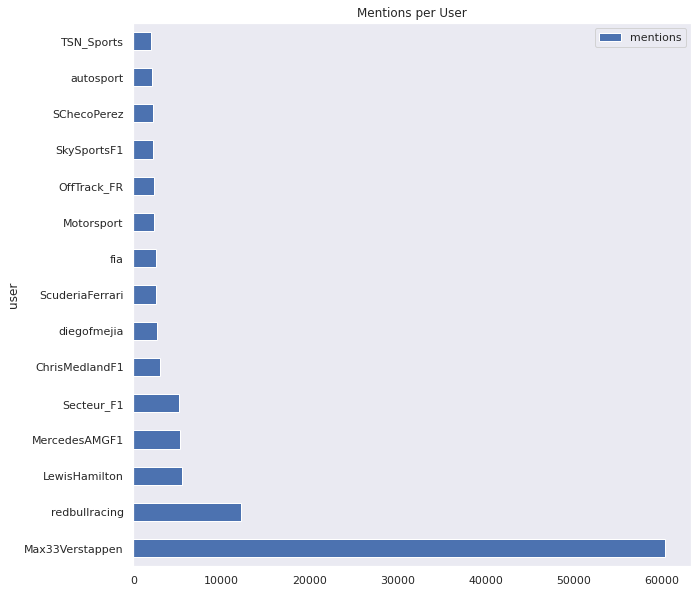

In [33]:
df_users_with_more_mentions = (tweets
          .select(F.explode("entities.user_mentions.screen_name").alias("user"))
          .where((F.lower('user') != 'f1'))
          .groupBy("user")
          .agg(F.count("*").alias("mentions"))
          .orderBy(F.desc("mentions"))
          .limit(15))
df_users_with_more_mentions.toPandas().plot.barh(x = 'user', y = 'mentions', title = 'Mentions per User', figsize=(10,10))

As **UK** was the location with more interactions, we wanted to find which were the user account that people mentioned the most.
Here, Lewis Hamilton is one the most mentioned drivers.

<AxesSubplot:title={'center':'Mentions per User'}, ylabel='user'>

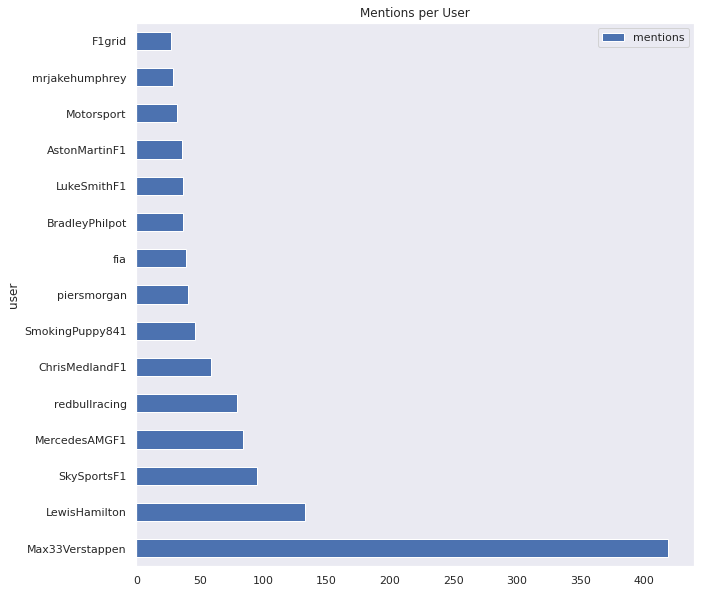

In [34]:
df_UK = (tweets
          .select(F.explode("entities.user_mentions.screen_name").alias("user"))
          .where((F.lower('user') != 'f1') & ((tweets.user.location == "London, England") | (tweets.user.location == "United Kingdom")))
          .groupBy("user")
          .agg(F.count("*").alias("mentions"))
          .orderBy(F.desc("mentions"))
          .limit(15))
df_UK.toPandas().plot.barh(x = 'user', y = 'mentions', title = 'Mentions per User', figsize=(10,10))

We wanted to do the same but with Mexico. We found that, in order to take advantage of his image and popularity in this country, F1 and Red Bull Team should take advantage of Checo Perez to promote their events.

<AxesSubplot:title={'center':'Mentions per User'}, ylabel='user'>

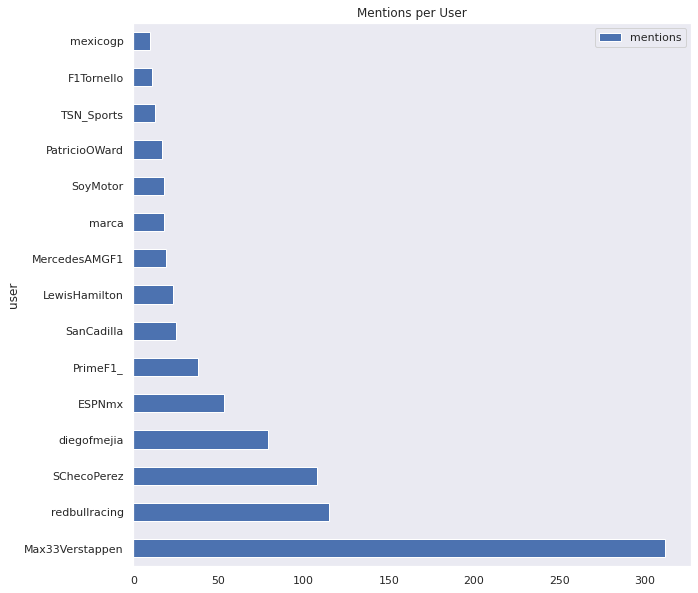

In [35]:
df_Mexico = (tweets
          .select(F.explode("entities.user_mentions.screen_name").alias("user"))
          .where((F.lower('user') != 'f1') & (tweets.user.location == "México"))
          .groupBy("user")
          .agg(F.count("*").alias("mentions"))
          .orderBy(F.desc("mentions"))
          .limit(15))
df_Mexico.toPandas().plot.barh(x = 'user', y = 'mentions', title = 'Mentions per User', figsize=(10,10))

## Tweets per day

We wanted to count the number of tweets per day. The final race was obviusly the day with more number of tweets collected.

*There were also a significant number of tweets with `None` location* 

In [36]:
tweets.select((F.split('created_at', " ")[2]).alias('Day'))\
                .groupBy('Day')\
                .agg(F.count("*").alias("total"))\
                .orderBy(F.asc("Day"))\
                .toPandas()

,Day,total
0,None,3657
1,05,807
2,06,1048
3,07,1434
4,08,1013
5,09,2262
6,10,5953
7,11,11838
8,12,385030


**Top 10 more popular hashtags**<br/>

- We wanted to filter out the **#F1** and **#Formula1** hashtags, since all the tweets we stored used these hashtags.

In [37]:
df = (tweets
      .select(F.explode("entities.hashtags.text").alias("hashtag"))
      .where((F.lower('hashtag') != 'f1') & (F.lower('hashtag') != 'formula1'))
      .groupBy(F.lower("hashtag"))
      .agg(F.count("*").alias("total"))
      .orderBy(F.desc("total"))
      .limit(10))
      
df.toPandas()

,lower(hashtag),total
0,abudhabigp,147737
1,historymade,38908
2,abudabhigp,8947
3,f1jp,8614
4,simplylovely,7770
5,f1finale,5793
6,verstappen,4001
7,redbull,3739
8,f1アブダビgp,3383
9,maxverstappen,3126


As with the user accounts, here we wanted to go deeper and look for the most relevant hashtags for the users in Mexico...

In [38]:
df_Hashtags_Mexico = (tweets
      .select(F.explode("entities.hashtags.text").alias("hashtag"))
      .where((F.lower('hashtag') != 'f1') & (F.lower('hashtag') != 'formula1') & (tweets.user.location == "México"))
      .groupBy(F.lower("hashtag"))
      .agg(F.count("*").alias("total"))
      .orderBy(F.desc("total"))
      .limit(10))
      
df_Hashtags_Mexico.toPandas()

,lower(hashtag),total
0,abudhabigp,661
1,historymade,168
2,simplylovely,49
3,verstappen,23
4,checoperez,21
5,hamilton,20
6,checo,20
7,redbull,19
8,abudabhigp,16
9,f1finale,16
